In [5]:
!pip install -r requirements.txt -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 2.0.2 requires Jinja2>=3.0, but you have jinja2 2.11.3 which is incompatible.


In [2]:
import models
import data
import itertools
import multiprocessing as mp
import os
import numpy as np

In [1]:
todo = {}
todo["cifar10"] = """Addepalli2021Towards_WRN34
Gowal2021Improving_70_16_ddpm_100m
Dai2021Parameterizing
Chen2021LTD_WRN34_10
Chen2021LTD_WRN34_20"""
todo["cifar100"] = """Gowal2020Uncovering
Cui2020Learnable_34_20_LBGAT6
Cui2020Learnable_34_10_LBGAT0
Chen2020Efficient
Wu2020Adversarial
Hendrycks2019Using
Rice2020Overfitting
Rebuffi2021Fixing_28_10_cutmix_ddpm
Rebuffi2021Fixing_R18_ddpm
Addepalli2021Towards_PARN18
Addepalli2021Towards_WRN34"""
todo["imagenet1k"] = """Wong2020Fast
Salman2020Do_R18
Salman2020Do_50_2"""

In [7]:
gpus = [1, 2, 3]
workers_per_gpu = 1

def gpu_worker(gpu, q):
    !python train.py --data_dir /data/datasets/ --output_dir /ssd1/checkpoints_robust_regularization/ --classifier "robustbench_Gowal2021Improving_70_16_ddpm_100m" --dataset "cifar10" --seed $gpu --batch_size 256 --gpu_id $gpu --num_workers 16 --scheduler "Step" --max_epochs 125 --cudnn_non_deterministic --robustbench_model_dir /ssd1/robustbench_leaderboard_models

if __name__ == '__main__':
    que = mp.Queue()
    
    processes = []
    for gpu in gpus * workers_per_gpu:
        p = mp.Process(target=gpu_worker, args=(gpu, que))
        p.start()
        processes.append(p)

Global seed set to 1
Global seed set to 3
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0:  83%|█████████▏ | 195/234 [02:52<00:34,  1.14it/s, loss=0.949, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 0:  83%|█████████▏ | 195/234 [02:52<00:34,  1.14it/s, loss=0.856, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 0:  83%|██████████  | 195/

In [6]:
gpus = [1, 2, 3]
workers_per_gpu = 1

def gpu_worker(gpu, q):
    while not q.empty():
        (clf, dataset) = q.get()
        !python train.py --data_dir /data/datasets/ --output_dir /ssd1/checkpoints_robustbench_models_normal_training/ --classifier $clf --dataset $dataset --seed $gpu --batch_size 256 --gpu_id $gpu --num_workers 16 --scheduler "Step" --max_epochs 125 --cudnn_non_deterministic --robustbench_model_dir /ssd1/robustbench_leaderboard_models

if __name__ == '__main__':
    que = mp.Queue()
    for dataset in ['imagenet1k']:
        for clf in todo[dataset].split("\n"):
            que.put(("robustbench_" + clf, dataset))
    
    processes = []
    for gpu in gpus * workers_per_gpu:
        p = mp.Process(target=gpu_worker, args=(gpu, que))
        p.start()
        processes.append(p)

NameError: name 'todo' is not defined

In [6]:
for p in processes:
    p.kill()

In [4]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from glob import glob
import torch
import robustbench

def replace_module(module, filter_fn, replacement_fn):
    for name, child in module.named_children():
        if filter_fn(child):
            replacement = replacement_fn(child)
            setattr(module, name, replacement)
            
    for child in module.children():
        replace_module(child, filter_fn, replacement_fn)

val_perfs = {}

ckpt_dir = "/ssd1/checkpoints_robustbench_models_normal_training/"
for ds in os.listdir(ckpt_dir):
    dataset_dir = os.path.join(ckpt_dir, ds)
    for model in os.listdir(dataset_dir):
        
        out_path = f"/ssd1/robustness_onnx_zoo/regular/hso_normal_training_{model}_{ds}_13.onnx"
        if not os.path.exists(out_path):
        
            model_dir = os.path.join(dataset_dir, model)
            for v in filter(lambda f: not f.startswith("."), os.listdir(model_dir)):
                try:
                    with open(os.path.join(model_dir, v, "hparams.yaml"), "r") as stream:
                        try:
                            params = yaml.safe_load(stream)
                        except yaml.YAMLError as exc:
                            pass

                    df = pd.read_csv(os.path.join(model_dir, v, "metrics.csv"))
                    e = int(df["epoch"].max())
                    print(e, params["hparams"]["gpu_id"], ds, v, df["acc/val"].max(), model)
                    val_perfs[model] = (df["acc/val"].dropna().values)


                    py_model = models.get_model(model, dataset=ds).cpu()
                    state = torch.load(glob(os.path.join(model_dir, v, "checkpoints/")+"*.ckpt")[0], map_location="cpu")
                    py_model.load_state_dict(dict((key[len("model."):], value) for (key, value) in state["state_dict"].items()))
                    replace_module(py_model, lambda m: type(m) == robustbench.model_zoo.architectures.dm_wide_resnet.Swish, lambda m: torch.nn.SiLU())

                    x = torch.randn((1, 3, 32, 32))
                    if ds == "imagenet1k":
                        x = torch.randn((1, 3, 224, 224))

                    with torch.no_grad():
                        if isinstance(py_model, torch.nn.DataParallel):  # extract the module from dataparallel models
                            py_model = py_model.module
                        py_model
                        py_model.eval()                                  # the converter works best on models stored on the CPU
                        torch.onnx.export(py_model,                      # model being run
                                          x,                          # model input (or a tuple for multiple inputs)
                                          out_path,                   # where to save the model (can be a file or file-like object)
                                          export_params=True,         # store the trained parameter weights inside the model
                                          opset_version=13)   

                except Exception as e: 
                    print(type(e), e)
                    print("# Error", ds, model, v)

124 2 cifar10 version_5 86.9190673828125 robustbench_Rebuffi2021Fixing_106_16_cutmix_ddpm


124 3 cifar10 version_3 87.91065979003906 robustbench_Gowal2020Uncovering_70_16


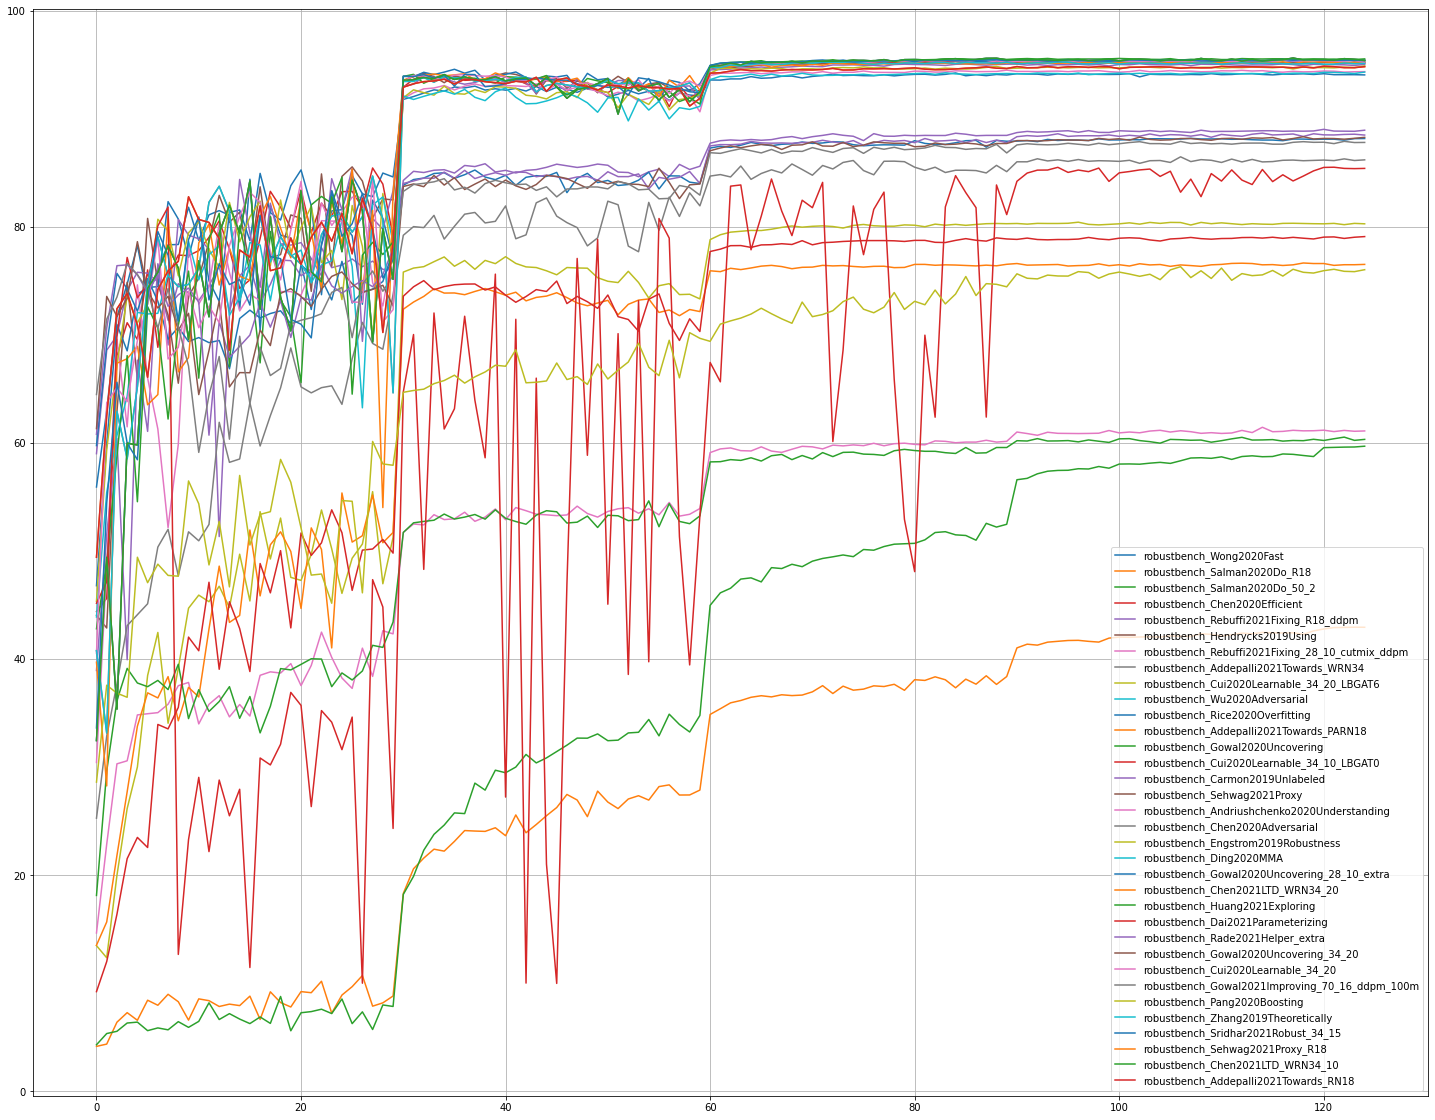

In [8]:
plt.figure(figsize=(25, 20))

for model, run in val_perfs.items():    
    plt.plot(run, label=model)
plt.grid()
plt.legend()